In [235]:
import numpy as np
import pandas as pd
import re

In [236]:
file_path = 'resultados_secao_absolutos/RICARDO_LUIS_REIS_NUNES.csv'
data = pd.read_csv(file_path, index_col=0)
name = file_path.split(r'/')[1].split('.')[0]

In [237]:
data.head(2)

,candidato,municipio,local,zona,secao,turno,votos_recebidos,ds_grau_escolaridade_ensino_fundamental_incompleto,ds_grau_escolaridade_superior_completo,ds_grau_escolaridade_superior_incompleto,...,ds_faixa_etaria_95_a_99_anos,ds_faixa_etaria_100_anos_ou_mais,ds_faixa_etaria_90_a_94_anos,ds_faixa_etaria_17_anos,ds_faixa_etaria_inválida,ds_genero_masculino,ds_genero_feminino,ds_genero_não_informado,eleitores_totais,percentual_votos
0,RICARDO LUIS REIS NUNES,71072,1333,408,323,2,101,99,14,9,...,0,0,0,0,0,150,218,0,368,0.274457
1,RICARDO LUIS REIS NUNES,71072,1333,408,323,2,101,99,14,9,...,0,0,0,0,0,150,218,0,368,0.274457


In [238]:
remove_cols = [col for col in data.columns if re.search('não_informado', col) or re.search('inválida', col)]
data = data.drop(remove_cols, axis=1)

In [239]:
pesos_escolaridade = {
    'ds_grau_escolaridade_analfabeto': 0,
    'ds_grau_escolaridade_lê_e_escreve': 1,
    'ds_grau_escolaridade_ensino_fundamental_incompleto': 2,
    'ds_grau_escolaridade_ensino_fundamental_completo': 3,
    'ds_grau_escolaridade_ensino_médio_incompleto': 4,
    'ds_grau_escolaridade_ensino_médio_completo': 5,
    'ds_grau_escolaridade_superior_incompleto': 6,
    'ds_grau_escolaridade_superior_completo': 7
}

# Calculando o score usando np.average com os pesos
data["escolaridade_score"] = data.apply(
    lambda row: np.average(
        [pesos_escolaridade[col] for col in pesos_escolaridade.keys()],  # Valores das colunas
        weights=[row[col] for col in pesos_escolaridade.keys()]  # Pesos associados às colunas
    ),
    axis=1
)

In [240]:
data = data.drop(pesos_escolaridade.keys(), axis=1)
data.head(1)

,candidato,municipio,local,zona,secao,turno,votos_recebidos,ds_raca_cor_branca,ds_raca_cor_parda,ds_raca_cor_indígena,...,ds_faixa_etaria_65_a_69_anos,ds_faixa_etaria_95_a_99_anos,ds_faixa_etaria_100_anos_ou_mais,ds_faixa_etaria_90_a_94_anos,ds_faixa_etaria_17_anos,ds_genero_masculino,ds_genero_feminino,eleitores_totais,percentual_votos,escolaridade_score
0,RICARDO LUIS REIS NUNES,71072,1333,408,323,2,101,18,19,0,...,7,0,0,0,0,150,218,368,0.274457,3.600543


In [241]:
def extrair_media_idade(col):
    try:
        return (float(col.split('_')[3]) + float(col.split('_')[5])) / 2
    except:
        try:
            return (float(col.split('_')[3]))
        except:
            return 0

In [242]:
etaria_cols = [col for col in data.columns if re.search('faixa_etaria', col)]
etaria_cols_weights = {
    col: extrair_media_idade(col)
    for col in etaria_cols
}

data['idade_score'] = data.apply(
    lambda row: np.average(
        [etaria_cols_weights[col] for col in etaria_cols_weights.keys()],
        weights=[row[col] for col in etaria_cols_weights.keys()]
    ),
    axis=1
)

In [243]:
data = data.drop(etaria_cols_weights.keys(), axis=1)
data.head(1)

,candidato,municipio,local,zona,secao,turno,votos_recebidos,ds_raca_cor_branca,ds_raca_cor_parda,ds_raca_cor_indígena,ds_raca_cor_preta,ds_raca_cor_amarela,ds_genero_masculino,ds_genero_feminino,eleitores_totais,percentual_votos,escolaridade_score,idade_score
0,RICARDO LUIS REIS NUNES,71072,1333,408,323,2,101,18,19,0,7,1,150,218,368,0.274457,3.600543,39.067935


### agrupamento por local de votação

In [244]:
data = data.groupby(['zona', 'local'], as_index=False).agg(
    votos_recebidos = ('votos_recebidos', 'sum'),
    eleitores = ('eleitores_totais', 'sum'),
    percentual_votos = ('percentual_votos', 'mean'),
    escolaridade_score = ('escolaridade_score', 'mean'),
    idade_score = ('idade_score', 'mean'),
    municipio = ('municipio', 'max')
)

In [245]:
data.head()

,zona,local,votos_recebidos,eleitores,percentual_votos,escolaridade_score,idade_score,municipio
0,1,1015,8750,40200,0.217137,5.654422,52.599433,71072
1,1,1023,6714,33884,0.198044,5.619402,51.465585,71072
2,1,1040,5052,24312,0.207797,4.464867,50.134327,71072
3,1,1058,5506,30308,0.181510,4.481594,48.490044,71072
4,1,1066,5066,24732,0.204757,5.034736,47.971087,71072


In [246]:
data[['percentual_votos', 'escolaridade_score', 'idade_score']].corr()

,percentual_votos,escolaridade_score,idade_score
percentual_votos,1.000000,0.212910,0.275259
escolaridade_score,0.212910,1.000000,0.280827
idade_score,0.275259,0.280827,1.000000


In [247]:
data.head(1)

,zona,local,votos_recebidos,eleitores,percentual_votos,escolaridade_score,idade_score,municipio
0,1,1015,8750,40200,0.217137,5.654422,52.599433,71072


In [248]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [249]:
data_filtered = data.loc[(data['percentual_votos'] < 1) & (data['percentual_votos'] > 10**(-2))]

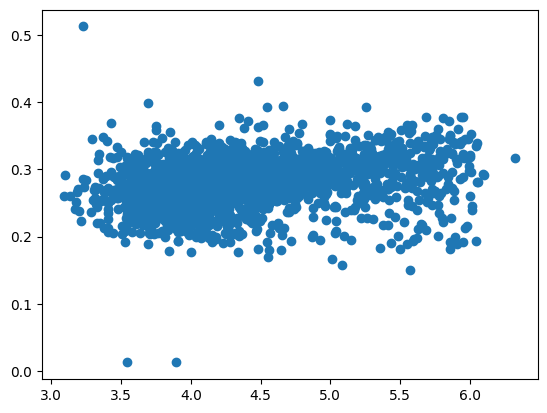

In [250]:
x = data_filtered['escolaridade_score'].values
y = data_filtered['percentual_votos'].values
plt.scatter(x,y)

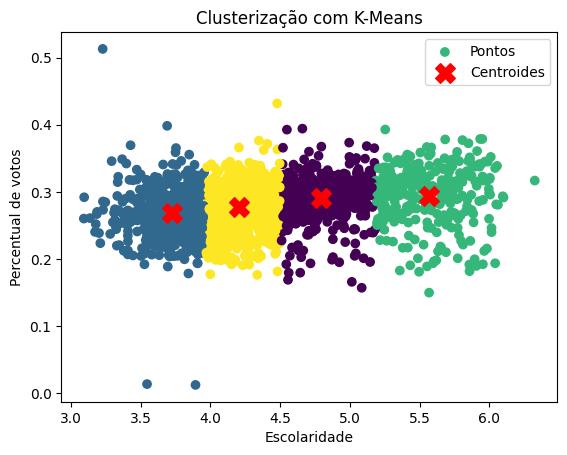

In [251]:
X = np.column_stack((x, y))
# 2. Aplicar K-Means
kmeans = KMeans(n_clusters=4, random_state=42)  # Configurar para 3 clusters
kmeans.fit(X)

# Obter os resultados
labels = kmeans.labels_           # Rótulos para cada ponto
centroids = kmeans.cluster_centers_  # Coordenadas dos centróides

# 3. Visualizar os resultados
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', label='Pontos')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroides')
plt.title('Clusterização com K-Means')
plt.xlabel('Escolaridade')
plt.ylabel('Percentual de votos')
plt.legend()
plt.show()

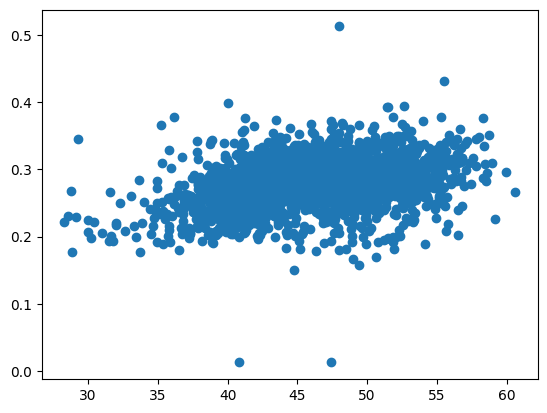

In [252]:
x = data_filtered['idade_score'].values
plt.scatter(x,y)

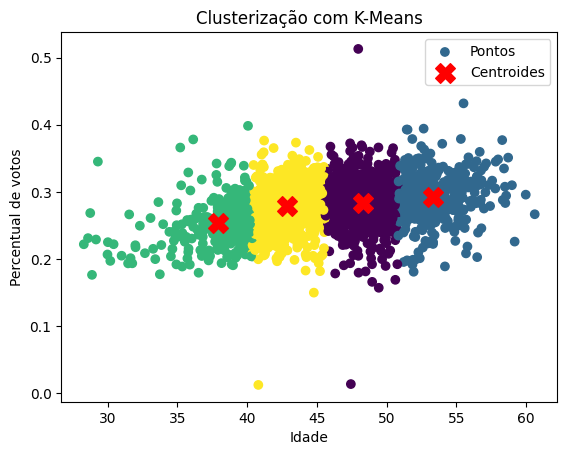

In [253]:
X = np.column_stack((x, y))
# 2. Aplicar K-Means
kmeans = KMeans(n_clusters=4, random_state=42)  # Configurar para 3 clusters
kmeans.fit(X)

# Obter os resultados
labels = kmeans.labels_           # Rótulos para cada ponto
centroids = kmeans.cluster_centers_  # Coordenadas dos centróides

# 3. Visualizar os resultados
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', label='Pontos')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroides')
plt.title('Clusterização com K-Means')
plt.xlabel('Idade')
plt.ylabel('Percentual de votos')
plt.legend()
plt.show()

In [254]:
from scipy.stats import binom

# Probabilidade genérica
p = data['votos_recebidos'].sum()/data['eleitores'].sum()

# Calcula a probabilidade para quantidade de votos recebidos
data['probabilidade'] = binom.pmf(k = data['votos_recebidos']//10, n = data['eleitores']//10, p = p)

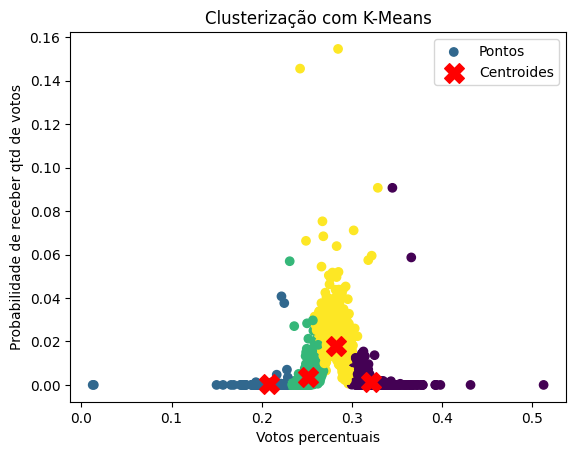

In [255]:
data_filtered = data.loc[(data['percentual_votos'] < 1) & (data['percentual_votos'] > 10**(-2))]
X = data_filtered[['percentual_votos', 'probabilidade']].values
# 2. Aplicar K-Means
kmeans = KMeans(n_clusters=4, random_state=42)  # Configurar para 3 clusters
kmeans.fit(X)

# Obter os resultados
labels = kmeans.labels_           # Rótulos para cada ponto
centroids = kmeans.cluster_centers_  # Coordenadas dos centróides

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', label='Pontos')  # Usar X para as dimensões
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroides')
plt.title('Clusterização com K-Means')
plt.xlabel('Votos percentuais')
plt.ylabel('Probabilidade de receber qtd de votos')
plt.legend()
plt.show()

In [256]:
data_filtered['clusters'] = labels
data_filtered.head()

C:\Users\ciaon\AppData\Local\Temp\ipykernel_8596\2726077203.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['clusters'] = labels


,zona,local,votos_recebidos,eleitores,percentual_votos,escolaridade_score,idade_score,municipio,probabilidade,clusters
0,1,1015,8750,40200,0.217137,5.654422,52.599433,71072,1.704648e-19,1
1,1,1023,6714,33884,0.198044,5.619402,51.465585,71072,6.177125e-28,1
2,1,1040,5052,24312,0.207797,4.464867,50.134327,71072,2.011367e-16,1
3,1,1058,5506,30308,0.181510,4.481594,48.490044,71072,4.321906e-36,1
4,1,1066,5066,24732,0.204757,5.034736,47.971087,71072,5.366832e-18,1


In [257]:
cluster_data = data_filtered.groupby('clusters').agg(
    percentual_votos = ('percentual_votos', 'mean'),
    prob_mean = ('probabilidade', 'mean'),
    qtd = ('probabilidade', 'size')
).sort_values('percentual_votos', ascending=False)
cluster_data

,percentual_votos,prob_mean,qtd
clusters,,,
0,0.321231,0.001346,592
3,0.282748,0.017954,770
2,0.251509,0.003557,494
1,0.208153,0.000538,191


In [258]:
import tse
import folium

In [259]:
analise = tse.TseAnalysis(
    database={
        'path': 'databases/eleicoes_2024.sql',
        'alias': 'geral' 
    }
)

In [260]:
analise.attach_database([])

Bancos carregados:
0) main
-path: d:\projects\tse-data\databases\eleicoes_2024.sql
--tables: 
-- locais
-----
2) geral
-path: d:\projects\tse-data\databases\eleicoes_2024.sql
--tables: 
-- locais
-----


In [261]:
cd_municipio = data_filtered['municipio'].values[0]
cd_municipio

71072

In [262]:
query = f"""
    SELECT
        CD_MUNICIPIO as municipio,
        NR_ZONA as zona,
        NR_SECAO as secao,
        NR_LOCAL_VOTACAO as local,
        NR_LATITUDE as latitude,
        NR_LONGITUDE as longitude
    FROM
        geral.locais
    WHERE
        CD_MUNICIPIO = '{cd_municipio}'
"""

In [263]:
locais_data = pd.read_sql_query(query, analise.conn)

In [264]:
locais_data.head(1)

,municipio,zona,secao,local,latitude,longitude
0,71072,413,314,1163,-23.628475,-46.605695


In [265]:
data_filtered.head(1)

,zona,local,votos_recebidos,eleitores,percentual_votos,escolaridade_score,idade_score,municipio,probabilidade,clusters
0,1,1015,8750,40200,0.217137,5.654422,52.599433,71072,1.704648e-19,1


In [266]:
data_filtered = pd.merge(
    data_filtered,
    locais_data,
    how='inner',
    on=['municipio','zona', 'local']   
)

In [267]:
data_filtered.head()

,zona,local,votos_recebidos,eleitores,percentual_votos,escolaridade_score,idade_score,municipio,probabilidade,clusters,secao,latitude,longitude
0,1,1015,8750,40200,0.217137,5.654422,52.599433,71072,1.704648e-19,1,18,-23.565159,-46.651062
1,1,1015,8750,40200,0.217137,5.654422,52.599433,71072,1.704648e-19,1,13,-23.565159,-46.651062
2,1,1015,8750,40200,0.217137,5.654422,52.599433,71072,1.704648e-19,1,10,-23.565159,-46.651062
3,1,1015,8750,40200,0.217137,5.654422,52.599433,71072,1.704648e-19,1,16,-23.565159,-46.651062
4,1,1015,8750,40200,0.217137,5.654422,52.599433,71072,1.704648e-19,1,27,-23.565159,-46.651062


In [268]:
cluster_map_data = data_filtered[['clusters', 'latitude', 'longitude']]

In [269]:
cluster_map_data.head(1)

,clusters,latitude,longitude
0,1,-23.565159,-46.651062


In [270]:
cluster_data

,percentual_votos,prob_mean,qtd
clusters,,,
0,0.321231,0.001346,592
3,0.282748,0.017954,770
2,0.251509,0.003557,494
1,0.208153,0.000538,191


In [275]:
# Criando um mapa centrado
m = folium.Map(location=[
    cluster_map_data['latitude'].mean(), 
    cluster_map_data['longitude'].mean()], zoom_start=15)

# Paleta de cores para clusters
colors = {0: 'purple', 1: 'blue', 2: 'gray', 3: 'orange'}
legenda = {
    2: 'abaixo do esperado',
    3: 'esperado',
    1: 'muito abaixo do esperado',
    0: 'acima do esperado'
}
# Criando camadas separadas por cluster
for cluster_id, group in cluster_map_data.groupby('clusters'):
    cluster_layer = folium.FeatureGroup(name=f'Apoio {legenda.get(cluster_id)}')
    for _, row in group.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=10,
            color=colors[cluster_id],
            fill=True,
            fill_color=colors[cluster_id],
            fill_opacity=0.7,
            popup=f"Cluster: {row['clusters']}"
        ).add_to(cluster_layer)
    cluster_layer.add_to(m)

In [276]:
legend_html = f"""
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 250px; height: 150px;
            background-color: white; z-index: 1000; font-size: 14px;
            border: 2px solid grey; border-radius: 10px; padding: 10px;">
    <b>Legenda</b><br>
    <i style="background:{colors.get(0)}; width:10px; height:10px; display:inline-block; margin-right:5px;"></i> Apoio {legenda.get(0)}<br>
    <i style="background:{colors.get(1)}; width:10px; height:10px; display:inline-block; margin-right:5px;"></i> Apoio {legenda.get(1)}<br>
    <i style="background:{colors.get(2)}; width:10px; height:10px; display:inline-block; margin-right:5px;"></i> Apoio {legenda.get(2)}<br>
    <i style="background:{colors.get(3)}; width:10px; height:10px; display:inline-block; margin-right:5px;"></i> Apoio {legenda.get(3)}<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

In [277]:
# Adicionando o controle de camadas
folium.LayerControl().add_to(m)

In [278]:
m.save(f"mapas/apoio_{name}.html")